In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

from config import DATA_FOLDER, RESULTS_FOLDER, METHYLATION_CSV_FILE, NUMBER_OF_CPG_SITES
from utils import get_patterns

In [2]:
%matplotlib inline

In [3]:
patterns = get_patterns(NUMBER_OF_CPG_SITES)
patterns

['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']

# Get data

In [4]:
# This is a big file
# Reading the file can be faster if it is saved as a pickle/parquet file
df = pd.read_csv(f'{DATA_FOLDER}/{METHYLATION_CSV_FILE}')

# Look at the data

In [5]:
df.head()

,strand,CpG_Coordinates,`000,`001,`010,`011,`100,`101,`110,`111,Sample_ID,Replicate,Tissue
0,r,10035:10044:10046,1077,9,0,0,0,0,0,4,1,Rep2,cfDNA
1,r,10035:10044:10053,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA
2,r,10035:10044:10058,1069,17,0,0,0,0,0,4,1,Rep2,cfDNA
3,r,10035:10044:10071,1072,14,0,0,0,0,0,4,1,Rep2,cfDNA
4,r,10035:10044:10075,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15392183 entries, 0 to 15392182
Data columns (total 13 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   strand           object
 1   CpG_Coordinates  object
 2   `000             int64 
 3   `001             int64 
 4   `010             int64 
 5   `011             int64 
 6   `100             int64 
 7   `101             int64 
 8   `110             int64 
 9   `111             int64 
 10  Sample_ID        int64 
 11  Replicate        object
 12  Tissue           object
dtypes: int64(9), object(4)
memory usage: 1.5+ GB


In [7]:
# There are 2 technical replicates and 2 tissue types
for x in ['strand', 'Replicate', 'Tissue']:
    print(df[x].unique())

['r' 'f']
['Rep2' 'Rep1']
['cfDNA' 'Islet']


In [8]:
# We don't have 2 technical replicates for Islet tissue type
# We have more samples of circulating free DNA
df.groupby(['strand', 'Tissue', 'Replicate'])['Sample_ID'].nunique()

strand  Tissue  Replicate
f       Islet   Rep1         32
        cfDNA   Rep1         47
                Rep2         48
r       Islet   Rep1         32
        cfDNA   Rep1         47
                Rep2         48
Name: Sample_ID, dtype: int64

In [9]:
# There are 80 samples
print(df['Sample_ID'].min())
print(df['Sample_ID'].max())
print(df['Sample_ID'].nunique())

1
80
80


# Coverage analysis

In [10]:
# Calculate the median and coefficient of variation (CV) for single CpG coverage in each tissue

# Coverage analysis can help us evaluate data quality

# The CpG_Coordinates are not split below, so this is not truly "single CpG coverage"
# I have treated the phased triple as a single epigenetic locus

# A common approach is to sum across all methylation patterns
# to get total coverage at that phased triple locus

df['Total_Coverage'] = df[patterns].sum(axis=1)
df_locus = df.groupby(['Tissue', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()
df_strand = df.groupby(['Tissue', 'strand', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()
df_rep = df.groupby(['Tissue', 'Replicate', 'CpG_Coordinates'])['Total_Coverage'].sum().reset_index()

In [11]:
# The mean values are higher than median
# The distribution is skewed (clearly visible in boxplots below)

stats = df_locus.groupby(['Tissue'])['Total_Coverage'].agg(['median', 'mean', 'std']).reset_index()
stats['CV'] = stats['std'] / stats['mean']
stats

,Tissue,median,mean,std,CV
0,Islet,4762.0,8534.123892,9733.194154,1.140503
1,cfDNA,90208.5,178228.548366,222046.851894,1.245855


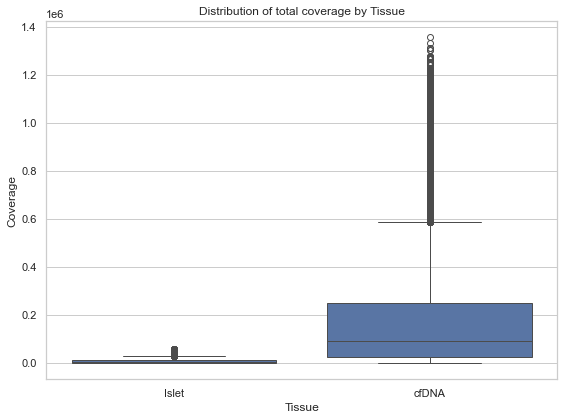

In [12]:
# There seem to be a lot of outliers
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))
sns.boxplot(x='Tissue', y='Total_Coverage', data=df_locus)
plt.title("Distribution of total coverage by Tissue")
plt.ylabel("Coverage")
plt.xlabel("Tissue")
plt.tight_layout()
plt.savefig(f'{RESULTS_FOLDER}/coverage_stats_tissue.svg')
plt.show()

## Coverage stats by Tissue and Strand

In [13]:
# The median values in forward strand are higher compared to reverse strand in both tissue types
df_strand_stats = df_strand.groupby(['Tissue','strand'])['Total_Coverage'].agg(['mean','median','std']).reset_index()
df_strand_stats['CV'] = df_strand_stats['std'] / df_strand_stats['mean']
df_strand_stats 

,Tissue,strand,mean,median,std,CV
0,Islet,f,4911.560906,2920.5,5521.360744,1.124156
1,Islet,r,3861.656847,1799.0,4674.749670,1.210555
2,cfDNA,f,101495.106485,54521.0,122704.943440,1.208974
3,cfDNA,r,81457.929502,30721.5,110953.440426,1.362095


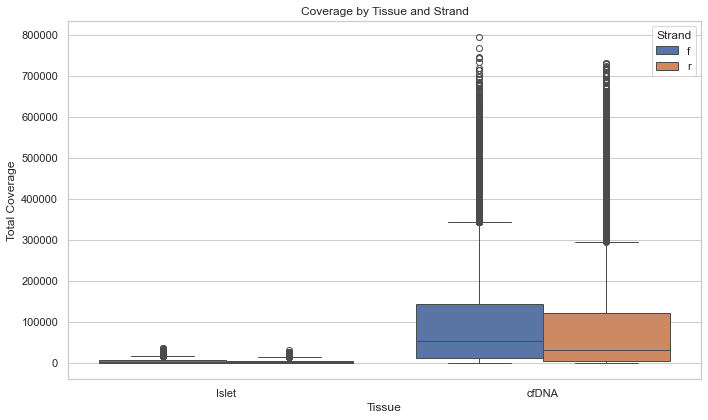

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Tissue', y='Total_Coverage',hue='strand',data=df_strand)
plt.title("Coverage by Tissue and Strand")
plt.xlabel("Tissue")
plt.ylabel("Total Coverage")
plt.legend(title="Strand")
plt.tight_layout()
plt.savefig(f'{RESULTS_FOLDER}/coverage_stats_strand.svg')
plt.show()

## Coverage stats by Tissue and Replicate

In [15]:
# In cfDNA, replicate 2 has higher median compared to replicate 1
# But the variation in cfDNA coverage within each replicate is similar
# It might be worth validating the wet lab protocols used in both replicates

df_rep_stats = df_rep.groupby(['Tissue','Replicate'])['Total_Coverage'].agg(['mean','median','std']).reset_index()
df_rep_stats['CV'] = df_rep_stats['std'] / df_rep_stats['mean']
df_rep_stats

,Tissue,Replicate,mean,median,std,CV
0,Islet,Rep1,8534.123892,4762.0,9733.194154,1.140503
1,cfDNA,Rep1,79456.485655,40297.5,98926.656313,1.245042
2,cfDNA,Rep2,98808.192434,49968.5,123128.895556,1.246141


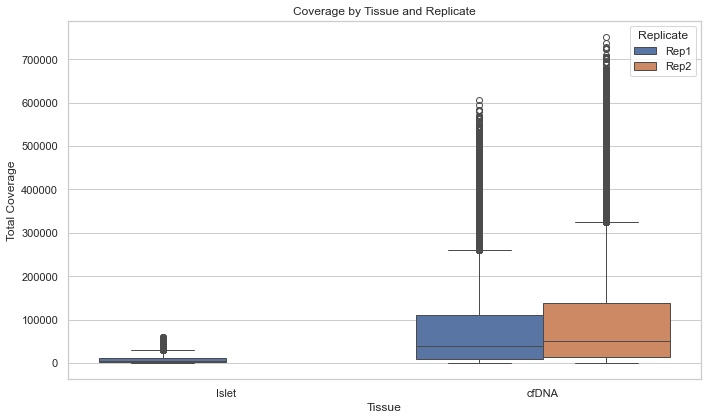

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Tissue', y='Total_Coverage', hue='Replicate', data=df_rep)
plt.title("Coverage by Tissue and Replicate")
plt.xlabel("Tissue")
plt.ylabel("Total Coverage")
plt.legend(title="Replicate")
plt.tight_layout()
plt.savefig(f'{RESULTS_FOLDER}/coverage_stats_replicate.svg')
plt.show()

# Biomarker identification

In [17]:
df_melt_polars = pl.read_parquet(f'{RESULTS_FOLDER}/methylation_data.parquet')
df_melt_polars.head()

strand,CpG_Coordinates,Sample_ID,Replicate,Tissue,pattern,coverage,PMP_ID
str,str,i64,str,str,str,i64,str
"""r""","""10035:10044:10046""",1,"""Rep2""","""cfDNA""","""`000""",1077,"""r_10035:10044:10046_`000"""
"""r""","""10035:10044:10053""",1,"""Rep2""","""cfDNA""","""`000""",1086,"""r_10035:10044:10053_`000"""
"""r""","""10035:10044:10058""",1,"""Rep2""","""cfDNA""","""`000""",1069,"""r_10035:10044:10058_`000"""
"""r""","""10035:10044:10071""",1,"""Rep2""","""cfDNA""","""`000""",1072,"""r_10035:10044:10071_`000"""
"""r""","""10035:10044:10075""",1,"""Rep2""","""cfDNA""","""`000""",1086,"""r_10035:10044:10075_`000"""


In [18]:
df_pmp = df_melt_polars.group_by(["Tissue", "PMP_ID"]).agg(pl.col("coverage").sum().alias("coverage"))
tissue_totals = df_pmp.group_by("Tissue").agg(pl.col("coverage").sum().alias("total_coverage"))

In [19]:
def compute_fisher(row, t1_total, t2_total):
    counts_t1 = row.get("Islet", 0)
    counts_t2 = row.get("cfDNA", 0)
    nonpmp_t1 = t1_total - counts_t1
    nonpmp_t2 = t2_total - counts_t2
    table = [[counts_t1, nonpmp_t1], 
             [counts_t2, nonpmp_t2]]
    # alternative="less" should minimise false positives
    # 1st row in table should be reference/baseline population
    odds, pval = fisher_exact(table, alternative="less")
    return counts_t1, counts_t2, odds, pval

In [20]:
df_pivot = df_pmp.pivot(index="PMP_ID", on="Tissue", values="coverage").fill_null(0)
t1_total = tissue_totals.filter(pl.col("Tissue") == "Islet").select("total_coverage").to_numpy()[0][0]
t2_total = tissue_totals.filter(pl.col("Tissue") == "cfDNA").select("total_coverage").to_numpy()[0][0]

results = []

for row in df_pivot.iter_rows():
    pmp_id = row[0] 
    row_data = dict(zip(df_pivot.columns[1:], row[1:]))
    counts_t1, counts_t2, odds, pval = compute_fisher(row_data, t1_total, t2_total)
    
    results.append({
        "PMP_ID": pmp_id,
        "counts_T1": counts_t1,
        "counts_T2": counts_t2,
        "odds_ratio": odds,
        "p_value": pval
    })

df_results = pl.DataFrame(results).sort("p_value")

In [21]:
# Ideally p_value should be low and odds_ratio should be high
# p_value shows whether coverage differs beyond random chance
# odds_ratio shows how big this difference is 

df_results = df_results.to_pandas()
df_results = df_results.sort_values(by=['p_value', 'odds_ratio'], ascending=[True, False])
df_results.head()

,PMP_ID,counts_T1,counts_T2,odds_ratio,p_value
1129,f_10319:10335:10343_`000,23799,653531,0.766693,0.0
66,f_10319:10343:10363_`000,21459,595989,0.758054,0.0
9088,f_10294:10312:10343_`000,17244,480713,0.755235,0.0
4465,f_10319:10363:10372_`000,19445,544013,0.752538,0.0
8554,f_10343:10363:10372_`000,24825,699173,0.747537,0.0


In [22]:
# Calculate the mean variant read fraction (VRF) for each PMP in both tissues
df_merged = df_pmp.join(tissue_totals, on='Tissue', how='left').with_columns(
    (pl.col("coverage") / pl.col("total_coverage")).alias("VRF")
)
df_vrf = df_merged.pivot(index='PMP_ID', on='Tissue', values='VRF')
rename_columns = {col: col + "_VRF" for col in df_vrf.columns if col != "PMP_ID"}
df_vrf = df_vrf.rename(rename_columns)
df_vrf.head()

PMP_ID,cfDNA_VRF,Islet_VRF
str,f64,f64
"""f_10071:10088:10146_`011""",1.8709e-9,8.0572e-8
"""r_7563:7590:7595_`100""",1.1906e-9,5.3715e-9
"""f_8378:8467:8512_`000""",7.2286e-9,1.7905e-8
"""f_13378:13381:13507_`010""",8.5043e-10,7.1619e-9
"""r_8573:8595:8658_`101""",1.8709e-9,1.7905e-9


In [23]:
df_results_pl = pl.from_pandas(df_results)
df_final = df_results_pl.join(df_vrf, on="PMP_ID", how='left')
df_final = df_final.to_pandas()

In [25]:
df_final = df_final.sort_values(by=['p_value', 'odds_ratio'], ascending=[True, False])
df_final.to_pickle(f'{RESULTS_FOLDER}/biomarker_results.pickle')

In [27]:
df_final.head(10)

,PMP_ID,counts_T1,counts_T2,odds_ratio,p_value,cfDNA_VRF,Islet_VRF
0,f_10319:10335:10343_`000,23799,653531,0.766693,0.0,0.000056,0.000043
1,f_10319:10343:10363_`000,21459,595989,0.758054,0.0,0.000051,0.000038
2,f_10294:10312:10343_`000,17244,480713,0.755235,0.0,0.000041,0.000031
3,f_10319:10363:10372_`000,19445,544013,0.752538,0.0,0.000046,0.000035
4,f_10343:10363:10372_`000,24825,699173,0.747537,0.0,0.000059,0.000044
5,f_10298:10335:10363_`000,14915,430810,0.728899,0.0,0.000037,0.000027
6,f_13794:13806:13811_`000,13732,398534,0.725436,0.0,0.000034,0.000025
7,f_10381:10393:10439_`000,14537,422473,0.724446,0.0,0.000036,0.000026
8,f_10298:10363:10381_`000,13151,382328,0.724191,0.0,0.000033,0.000024
9,f_10312:10319:10343_`000,20842,606242,0.723805,0.0,0.000052,0.000037


# Other questions

In [ ]:
# How does sequencing depth affect specificity confidence?

In [ ]:
# For the top 10 PMPs, estimate the threshold of reads required to confidently call Tissue #2 
# at a sequencing depth of 1 million reads.

In [ ]:
# Validate the hypothesis by comparing the specificity of the top 10 PMPs against individual CpG sites.